In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
from scipy.spatial import Delaunay
import time
import matplotlib.pyplot as plt

# ------------------------------
# 0. Configuration
# ------------------------------
class Config:
    # Experiment
    model_type = 'sparse'  # 'sparse' or 'dense'
    sparsity = 0.3
    lambda_sparse = 1e-4

    # Model
    num_layers = 4
    d_model = 128
    d_position = 2
    patch_size = 8

    # Training
    batch_size = 128
    epochs = 100
    lr = 1e-3
    weight_decay = 1e-4

    # Data
    num_classes = 100
    img_size = 32

config = Config()

# ------------------------------
# 1. Static Graph Builder
# ------------------------------
class StaticGraphBuilder:
    def __init__(self, mode='delaunay', window_size=8):
        self.mode = mode
        self.window_size = window_size
        self.cache = {}

    def build(self, positions):
        N = positions.shape[0]
        hash_key = f"{N}_{positions.mean().item():.4f}"

        if hash_key in self.cache:
            return self.cache[hash_key]

        if self.mode == 'delaunay' and positions.shape[1] > 1:
            tri = Delaunay(positions.cpu().numpy())
            edges = set()
            for simplex in tri.simplices:
                for i in range(3):
                    for j in range(i+1, 3):
                        a, b = sorted([simplex[i], simplex[j]])
                        edges.add((a, b))
            edge_index = torch.tensor(list(edges)).long().t().contiguous()

        elif self.mode == 'window' or positions.shape[1] == 1:
            edge_index = []
            for i in range(N):
                start = max(0, i - self.window_size)
                end = min(N, i + self.window_size + 1)
                for j in range(start, end):
                    if i != j:
                        edge_index.append([i, j])
            edge_index = torch.tensor(edge_index).long().t().contiguous()

        row, col = edge_index
        edge_attr = torch.norm(positions[row] - positions[col], dim=1)

        self.cache[hash_key] = (edge_index, edge_attr)
        return edge_index, edge_attr

# ------------------------------
# 2. Predictive Router (Corrected for Batching)
# ------------------------------
class PredictiveRouter(nn.Module):
    # __init__ is unchanged
    def __init__(self, d_model, k_dim=64, sparsity=0.3, is_sparse=True):
        super().__init__()
        self.d_model = d_model
        self.k_dim = k_dim
        self.sparsity = sparsity
        self.is_sparse = is_sparse
        self.W_pred = nn.Linear(d_model, d_model)
        self.W_q = nn.Linear(d_model, k_dim)
        self.W_k = nn.Linear(d_model, k_dim)
        self.U = nn.Parameter(torch.randn(k_dim, k_dim) * 0.02)
        self.v = nn.Sequential(
            nn.Linear(2 * d_model + 2, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.W_gate = nn.Linear(1, d_model)

    # Now expects a 2D tensor H of shape (B*N, D)
    def forward(self, H, edge_index, edge_attr, top_down=None):
        row, col = edge_index
        # H is now 2D, so N is its first dimension
        N, E = H.shape[0], edge_index.shape[1]

        # Top-down is also a 2D tensor now
        if top_down is not None:
            pred_j = self.W_pred(top_down[row])
            errors = torch.norm(H[col] - pred_j, dim=1, keepdim=True)
        else:
            errors = torch.zeros(E, 1, device=H.device)

        Q = self.W_q(H[row])
        K = self.W_k(H[col])
        bilinear = (Q @ self.U) * K
        bilinear = bilinear.sum(dim=1, keepdim=True)



        feat_linear = torch.cat([
            H[row],
            H[col],
            errors,
            edge_attr.unsqueeze(1)
        ], dim=1)


        linear_term = self.v(feat_linear)
        scores = bilinear + linear_term

        # Sparsification logic needs to know the original number of nodes per graph
        num_nodes_per_graph = H.shape[0] // config.batch_size # Assuming config is accessible
        if self.is_sparse and self.sparsity > 0:
            k = int(self.sparsity * num_nodes_per_graph)
            if k > 0:
                node_scores = torch.full_like(scores, -float('inf'))
                # This scatter is tricky with batches. A simpler approach is needed for now.
                # For a quick fix, we apply topk globally, which is an approximation.
                # A proper fix uses torch_scatter, but let's do this first.
                num_edges_to_keep = k * config.batch_size
                if scores.numel() > num_edges_to_keep:
                    threshold = torch.topk(scores.view(-1), num_edges_to_keep).values[-1]
                    mask = (scores >= threshold).float()
                    scores = scores * mask

        gates = torch.sigmoid(self.W_gate(scores))
        return gates


# ------------------------------
# 3. Perceptual Capsule Unit
# ------------------------------
class PCU(nn.Module):
    # __init__ is unchanged
    def __init__(self, d_model):
        super().__init__()
        self.W_self = nn.Linear(d_model, d_model)
        self.W_msg = nn.Linear(d_model, d_model)
        self.activation = nn.GELU()

    # Now expects a 2D tensor H of shape (B*N, D)
    def forward(self, H, gates, edge_index):
        row, col = edge_index
        self_part = self.W_self(H)
        messages = self.W_msg(H[col])
        modulated = messages * gates

        # index_add_ works correctly on the flattened 2D tensor
        agg = torch.zeros_like(H)
        agg = agg.index_add_(0, row, modulated)
        return self.activation(self_part + agg)




# ------------------------------
# 4. Top-Down Aggregator
# ------------------------------
class TopDownAggregator(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.W_t = nn.Linear(d_model, d_model)

    def forward(self, H_lower, H_higher, hierarchy):
        parent_signals = hierarchy @ H_higher
        modulation = self.W_t(parent_signals)
        return H_lower + modulation



# ------------------------------
# 5. AFMP Layer (Corrected for Batching)
# ------------------------------
class AFMPLayer(nn.Module):
    # __init__ is unchanged
    def __init__(self, d_model, d_position, sparsity=0.3, is_sparse=True):
        super().__init__()
        self.router = PredictiveRouter(d_model, sparsity=sparsity, is_sparse=is_sparse)
        self.pcu = PCU(d_model)

    def forward(self, H, edge_index, edge_attr, top_down=None):
        # H arrives as (B, N, D)
        batch_size, num_nodes, d_model = H.shape

        # --- FIX: Flatten for graph operations ---
        H_flat = H.view(-1, d_model) # Shape: (B*N, D)

        # Prepare top_down if it exists
        top_down_flat = None
        if top_down is not None:
            top_down_flat = top_down.view(-1, d_model)
        # --- END FIX ---

        # The router now operates on flattened tensors
        gates = self.router(H_flat, edge_index, edge_attr, top_down_flat)

        # The PCU also operates on the flattened tensor
        H_updated_flat = self.pcu(H_flat, gates, edge_index)

        # --- FIX: Reshape back to batched format ---
        H_out = H_updated_flat.view(batch_size, num_nodes, d_model)
        # --- END FIX ---

        return H_out, gates




# ------------------------------
# 6. Sparsity Regularizer
# ------------------------------
class SparsityRegularizer(nn.Module):
    def __init__(self, lambda_sparse=0.01):
        super().__init__()
        self.lambda_sparse = lambda_sparse

    def forward(self, gates):
        return self.lambda_sparse * torch.mean(torch.abs(gates))


# ------------------------------
# 7. Full AFMP Model (Updated for Hierarchy Ablation)
# ------------------------------
class AFMP(nn.Module):
    def __init__(self, num_layers, d_model, d_position, num_classes,
                 img_size=32, patch_size=8, sparsity=0.3, is_sparse=True,
                 use_top_down=True): # <-- FIX 1: Add new control flag
        super().__init__()
        self.patch_size = patch_size
        self.img_size = img_size
        self.use_top_down = use_top_down # <-- FIX 2: Store the flag

        self.num_patches = (img_size // patch_size) ** 2
        self.embed = nn.Linear(3 * patch_size * patch_size, d_model)
        self.position_embed = nn.Linear(2, d_model)

        # Precompute static positions (2D tensor)
        grid = torch.arange(0, img_size, patch_size) + patch_size / 2
        grid_x, grid_y = torch.meshgrid(grid, grid, indexing='ij')
        static_positions = torch.stack([grid_x, grid_y], dim=-1).reshape(-1, 2)

        # Build graph ONCE and store everything as buffers
        graph_builder = StaticGraphBuilder()
        edge_index, edge_attr = graph_builder.build(static_positions)

        self.register_buffer('static_positions', static_positions)
        self.register_buffer('edge_index', edge_index)
        self.register_buffer('edge_attr', edge_attr)

        self.layers = nn.ModuleList([
            AFMPLayer(d_model, d_position, sparsity, is_sparse)
            for _ in range(num_layers)
        ])

        # Only create aggregators if they will be used
        if self.use_top_down:
            self.top_down_aggregators = nn.ModuleList([
                TopDownAggregator(d_model) for _ in range(num_layers-1)
            ])

        self.readout = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(d_model, num_classes)
        )

        self.reg = SparsityRegularizer(
            lambda_sparse=config.lambda_sparse if is_sparse else 0.0
        )

    def forward(self, images, return_internals=False):
        batch_size = images.size(0)
        p = self.patch_size

        patches = images.unfold(2, p, p).unfold(3, p, p)
        patches = patches.permute(0, 2, 3, 1, 4, 5)
        patches = patches.contiguous().view(batch_size, -1, 3 * p * p)

        # Create position embedding for the batch
        pos_emb = self.position_embed(self.static_positions.expand(batch_size, -1, -1))
        H = self.embed(patches) + pos_emb

        # --- Bottom-up pass ---
        # The predictive routing still needs top-down signals during the bottom-up pass
        # This part remains the same to ensure a fair comparison of the final refinement step.
        states = []
        all_gates = []
        current = H
        for i, layer in enumerate(self.layers):
            # The top-down signal for routing comes from the PREVIOUS layer's output
            top_down_signal_for_routing = states[i-1] if i > 0 else None
            current, gates = layer(current, self.edge_index, self.edge_attr, top_down=top_down_signal_for_routing)
            states.append(current)
            all_gates.append(gates)

        # --- FIX 3: Conditionally execute the Top-Down Refinement Pass ---
        if self.use_top_down:
            for i in range(len(self.layers)-2, -1, -1):
                hierarchy = self.create_hierarchy_map(states[i].shape[1], states[i+1].shape[1])
                hierarchy = hierarchy.to(images.device)
                # The states are refined in-place
                states[i] = self.top_down_aggregators[i](states[i], states[i+1], hierarchy)

        # Readout from the final state (which is either refined or not)
        logits = self.readout(states[-1].permute(0, 2, 1)).squeeze(-1)

        sparsity_loss = self.reg(torch.cat(all_gates)) if all_gates else torch.tensor(0.0, device=images.device)

        if return_internals:
            return logits, sparsity_loss, all_gates, states
        else:
            return logits, sparsity_loss

    def create_hierarchy_map(self, n_low, n_high):

        if n_low == 0 or n_high == 0: return torch.zeros(n_low, n_high)
        if n_low % n_high != 0:
            ratio = n_low // n_high
        else:
            ratio = n_low // n_high
        if ratio == 0: return torch.zeros(n_low, n_high)

        map_matrix = torch.zeros(n_low, n_high)
        for i in range(n_high):
            start_idx = i * ratio
            end_idx = (i + 1) * ratio if i < n_high - 1 else n_low
            map_matrix[start_idx:end_idx, i] = 1.0
        return map_matrix


import os

# ------------------------------
# NEW: VisualizationHook Class
# ------------------------------
class VisualizationHook:
    def __init__(self, model, dataloader, device, vis_epoch_interval=10):
        self.model = model
        self.dataloader = dataloader # Use the validation loader
        self.device = device
        self.vis_epoch_interval = vis_epoch_interval

        # Create a directory to save visualizations
        self.vis_dir = f'visualizations_{config.model_type}'
        os.makedirs(self.vis_dir, exist_ok=True)

        # Get a fixed batch of images for consistent visualization
        self.sample_batch = next(iter(self.dataloader))

    def run(self, epoch):
        """Main function to generate and save all visualizations for a given epoch."""
        if epoch % self.vis_epoch_interval != 0 and epoch != config.epochs -1:
            return

        print(f"\n--- Generating visualizations for Epoch {epoch+1} ---")
        self.model.eval() # Set model to evaluation mode

        with torch.no_grad():
            # Get a single image from our fixed batch
            image, _ = self.sample_batch
            image = image[0:1].to(self.device) # Take the first image, keep batch dim

            # Get the model's internal states
            gates_per_layer, H_per_layer = self.get_internals(image)

            # --- Generate Plots ---
            # 1. Plot the communication graph
            # Let's visualize the gates from a middle layer (e.g., layer 2)
            middle_layer_idx = config.num_layers // 2
            self.plot_communication_graph(
                image.squeeze(0),
                gates_per_layer[middle_layer_idx],
                epoch
            )

            # 2. Plot the sparsity per layer
            self.plot_sparsity_stats(gates_per_layer, epoch)

            # 3. Plot gate value distribution
            self.plot_gate_distribution(gates_per_layer[middle_layer_idx], epoch, middle_layer_idx)

        print("--- Visualizations saved ---")

    def get_internals(self, image_batch):
        """Modified forward pass to capture intermediate gates and states."""
        # This requires modifying the model slightly to return these values
        # Or re-implementing the forward logic here. Let's assume the model can return them.
        logits, sparsity_loss, all_gates, all_states = self.model(image_batch, return_internals=True)
        return all_gates, all_states
    def plot_communication_graph(self, image_tensor, gates, epoch):
        """
        UPDATED: Plots ALL communication pathways on top of the image,
        with line width and transparency determined by gate strength.
        """
        # Un-normalize the image for display
        inv_normalize = transforms.Normalize(
            mean=[-0.5071/0.2675, -0.4867/0.2565, -0.4408/0.2761],
            std=[1/0.2675, 1/0.2565, 1/0.2761]
        )
        img = inv_normalize(image_tensor).cpu().permute(1, 2, 0)

        # Get graph structure and gate strengths
        edge_index = self.model.edge_index.cpu()
        positions = self.model.static_positions.cpu()
        gate_strengths = gates.mean(dim=1).cpu().numpy()

        plt.figure(figsize=(8, 8))
        plt.imshow(img, interpolation='nearest') # Use 'nearest' for crisp pixels

        # Plot ALL connections, but vary their appearance based on strength
        for i in range(edge_index.shape[1]):
            start_node, end_node = edge_index[:, i]
            p_start = positions[start_node]
            p_end = positions[end_node]
            strength = gate_strengths[i]

            # Make strong connections thick and opaque, weak ones thin and transparent.
            # We scale the values to make the visualization clearer.
            # Alpha will range from nearly transparent to mostly opaque.
            alpha = max(0.01, strength * 0.6)
            # Line width will be proportional to strength.
            lw = strength * 3.0

            # Only draw lines with a minimum visibility to avoid clutter
            if alpha > 0.05:
                plt.plot([p_start[1], p_end[1]], [p_start[0], p_end[0]],
                         color='cyan',
                         alpha=alpha,
                         lw=lw)

        plt.title(f'Learned Communication Graph (Epoch {epoch+1})', fontsize=16)
        plt.axis('off')
        plt.savefig(f'{self.vis_dir}/comm_graph_epoch_{epoch+1}.png', bbox_inches='tight', dpi=150)
        plt.close()

    def plot_sparsity_stats(self, gates_per_layer, epoch):
        """
        UPDATED: Plots a bar chart of sparsity per layer using a more
        meaningful threshold of 0.5 to define a "pruned" connection.
        """
        sparsities = []
        layer_indices = range(len(gates_per_layer))

        for gates in gates_per_layer:
            # A gate is considered "pruned" if its value is closer to 0 than to 1.
            # A threshold of 0.5 is a robust way to measure this learned decision.
            threshold = 0.5
            sparsity = (gates.mean(dim=1) < threshold).float().mean().item()
            sparsities.append(sparsity * 100)

        plt.figure(figsize=(8, 5))
        plt.bar(layer_indices, sparsities, color='dodgerblue')
        plt.title(f'Connection Sparsity per Layer (Epoch {epoch+1})', fontsize=14)
        plt.xlabel('Layer Index')
        plt.ylabel('Sparsity (% of connections pruned)')
        plt.xticks(layer_indices)
        plt.ylim(0, 100)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.savefig(f'{self.vis_dir}/sparsity_stats_epoch_{epoch+1}.png')
        plt.close()


    def plot_gate_distribution(self, gates, epoch, layer_idx):
        """Plots a histogram of gate activation values."""
        gate_values = gates.mean(dim=1).view(-1).cpu().numpy()

        plt.figure(figsize=(8, 5))
        plt.hist(gate_values, bins=50, color='mediumseagreen')
        plt.title(f'Gate Activation Distribution - Layer {layer_idx} (Epoch {epoch+1})')
        plt.xlabel('Mean Gate Value')
        plt.ylabel('Frequency')
        plt.yscale('log')
        plt.savefig(f'{self.vis_dir}/gate_dist_epoch_{epoch+1}.png')
        plt.close()





# ------------------------------
# 8. Data Preparation
# ------------------------------
def prepare_cifar100(batch_size=128):
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
    ])

    train_set = torchvision.datasets.CIFAR100(
        root='./data', train=True, download=True, transform=transform_train)
    test_set = torchvision.datasets.CIFAR100(
        root='./data', train=False, download=True, transform=transform_test)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, test_loader

# ------------------------------
# 9. Training Functions (Simplified)
# ------------------------------
def train_epoch(model, train_loader, optimizer, device, epoch):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0
    sparsity_loss_sum = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        batch_size = inputs.size(0)

        optimizer.zero_grad()

        # Forward pass (model handles patching internally)
        logits, sparsity_loss = model(inputs)
        task_loss = F.cross_entropy(logits, targets)
        loss = task_loss + sparsity_loss

        # Backward pass
        loss.backward()
        optimizer.step()

        # Metrics
        _, predicted = logits.max(1)
        total_correct += predicted.eq(targets).sum().item()
        total_samples += batch_size
        total_loss += loss.item()
        sparsity_loss_sum += sparsity_loss.item()

        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch} | Batch: {batch_idx}/{len(train_loader)} '
                  f'| Loss: {loss.item():.4f} | Acc: {100.*total_correct/total_samples:.2f}%')

    avg_loss = total_loss / len(train_loader)
    avg_acc = 100. * total_correct / total_samples
    avg_sparsity_loss = sparsity_loss_sum / len(train_loader)

    return avg_loss, avg_acc, avg_sparsity_loss

def validate(model, test_loader, device):
    model.eval()
    total_correct, total_samples = 0, 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            batch_size = inputs.size(0)

            # Forward pass (model handles patching internally)
            logits, _ = model(inputs)

            # Metrics
            _, predicted = logits.max(1)
            total_correct += predicted.eq(targets).sum().item()
            total_samples += batch_size

    accuracy = 100. * total_correct / total_samples
    return accuracy

# ------------------------------
# 10. Memory Measurement (Fixed)
# ------------------------------
def get_peak_memory(model, device):
    """Measure peak GPU memory usage during a forward pass"""
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats(device)

    # Create dummy input
    dummy_input = torch.randn(2, 3, config.img_size, config.img_size).to(device)

    # Forward pass
    model(dummy_input)

    # Get peak memory in MB
    peak_mem_mb = torch.cuda.max_memory_allocated(device) / (1024 ** 2)
    return peak_mem_mb


# ------------------------------
# 11. Saving and Main Experiment
# ------------------------------

def save_results(model_type, model, history, best_acc, peak_mem):
    """Saves the model state, training history, and final metrics."""
    print(f"\n--- Saving results for {model_type.upper()} model ---")


    torch.save(model.state_dict(), f'afmp_{model_type}_final.pth')
    print(f"Final model state saved to afmp_{model_type}_final.pth")

    # 2. Create a results dictionary
    results = {
        'model_type': model_type,
        'best_val_accuracy': best_acc,
        'peak_memory_mb': peak_mem,
        'training_history': history
    }

    # 3. Save the results dictionary to a JSON file
    # JSON is human-readable and easy to load back into Python
    results_filename = f'results_{model_type}.json'
    with open(results_filename, 'w') as f:
        json.dump(results, f, indent=4)
    print(f"Training history and metrics saved to {results_filename}")
    print("--------------------------------------------------")

# ------------------------------
# 11. Main Experiment (UPDATED for Hierarchy Ablation)
# ------------------------------
def run_experiment(model_name, use_top_down):
    """
    Runs a single, complete training and validation experiment.

    Args:
        model_name (str): A descriptive name for saving files (e.g., 'sparse_with_top_down').
        use_top_down (bool): Flag to control the use of the top-down refinement pass.
    """
    # Set config for this specific ablation study
    config.model_type = 'sparse'
    config.sparsity = 0.3
    config.lambda_sparse = 1e-4

    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Model - The use_top_down flag is passed here
    model = AFMP(
        num_layers=config.num_layers,
        d_model=config.d_model,
        d_position=config.d_position,
        num_classes=config.num_classes,
        img_size=config.img_size,
        patch_size=config.patch_size,
        sparsity=config.sparsity,
        is_sparse=(config.model_type == 'sparse'),
        use_top_down=use_top_down  # <-- CRUCIAL CHANGE
    ).to(device)

    # Print model size
    num_params = sum(p.numel() for p in model.parameters())
    print(f"Model: {model_name.upper()} | Parameters: {num_params/1e6:.2f}M")

    # Optimizer
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config.lr,
        weight_decay=config.weight_decay
    )

    # Learning Rate Scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 'max', patience=5, factor=0.2, verbose=True
    )

    # Data and Visualization
    train_loader, test_loader = prepare_cifar100(config.batch_size)
    visualizer = VisualizationHook(model, test_loader, device, vis_epoch_interval=10)

    # Training history
    history = {
        'train_loss': [], 'train_acc': [], 'val_acc': [],
        'sparsity_loss': [], 'time': []
    }

    best_acc = 0
    start_time = time.time()

    # Training loop
    for epoch in range(config.epochs):
        epoch_start = time.time()
        train_loss, train_acc, sparsity_loss = train_epoch(
            model, train_loader, optimizer, device, epoch)

        val_acc = validate(model, test_loader, device)
        scheduler.step(val_acc)
        visualizer.run(epoch)

        # Record history
        epoch_time = time.time() - epoch_start
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['sparsity_loss'].append(sparsity_loss)
        history['time'].append(epoch_time)

        # Print summary
        print(f"Epoch {epoch+1}/{config.epochs} | "
              f"Time: {epoch_time:.1f}s | "
              f"Train Loss: {train_loss:.4f} | "
              f"Train Acc: {train_acc:.2f}% | "
              f"Val Acc: {val_acc:.2f}% | "
              f"Sparsity Loss: {sparsity_loss:.6f}")

        # Save best model using the descriptive model_name
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f'afmp_{model_name}_best.pth')

    total_time = time.time() - start_time
    print(f"Training completed in {total_time/60:.1f} minutes")
    print(f"Best validation accuracy for {model_name.upper()}: {best_acc:.2f}%")

    # Measure peak memory
    peak_mem = get_peak_memory(model, device)

    return model, history, best_acc, peak_mem

import json








In [ ]:




# ------------------------------
# 12. Main Function (UPDATED for Hierarchy Ablation)
# ------------------------------
def main():
    '''
    # --- RUN #1: THE NEW CONTROL GROUP (With Top-Down Refinement) ---
    # This is the full, powerful model with the updated logic.
    print("="*50)
    print(f"RUNNING HIERARCHY STUDY: CONTROL (WITH TOP-DOWN) sparsity : {config.sparsity}, Lambda sparse : {config.lambda_sparse}")
    print("="*50)

    control_name = 'sparse_with_top_down'
    control_model, control_history, control_acc, control_mem = run_experiment(
        model_name=control_name,
        use_top_down=True
    )
    # Save results immediately after completion
    save_results(control_name, control_model, control_history, control_acc, control_mem)'''


    # --- RUN #2: THE ABLATED MODEL (Without Top-Down Refinement) ---
    # This model uses the identical powerful bottom-up pass but skips the final refinement.
    print("\n" + "="*50)
    print("RUNNING HIERARCHY STUDY: ABLATION (NO TOP-DOWN)")
    print("="*50)

    ablation_name = 'sparse_no_top_down'
    ablation_model, ablation_history, ablation_acc, ablation_mem = run_experiment(
        model_name=ablation_name,
        use_top_down=False
    )
    # Save results immediately after completion
    save_results(ablation_name, ablation_model, ablation_history, ablation_acc, ablation_mem)


    # --- FINAL ANALYSIS ---
    # After both runs are complete, you will have two new JSON files:
    # - results_sparse_with_top_down.json
    # - results_sparse_no_top_down.json
    # You can then load these to create the final comparison plots for your paper.

    print("\n" + "="*50)
    print("HIERARCHY ABLATION STUDY COMPLETE")
    print("="*50)
    print("Final Comparison:")
    print(f"{'Model Variant':<30} {'Val Accuracy':<15}")
    print("-"*45)
    print(f"{'AFMP with Top-Down':<30} {control_acc:.2f}%")
    print(f"{'AFMP without Top-Down':<30} {ablation_acc:.2f}%")

    # Example of how to load the data back if needed:
    # with open('results_dense.json', 'r') as f:
    #     dense_results = json.load(f)
    # with open('results_sparse.json', 'r') as f:
    #     sparse_results = json.load(f)
    # dense_history = dense_results['training_history']
    # sparse_history = sparse_results['training_history']
    # dense_acc = dense_results['best_val_accuracy']
    # ...and so on.
    '''

    print(f"{'Model Variant':<20} {'Val Accuracy':<15} {'Peak Memory (MB)':<20}")
    print("-"*65)
    print(f"{'AFMP-Dense':<20} {dense_acc:.2f}% {dense_mem:.2f}")'''
    print(f"{'AFMP-Tiny':<20} {sparse_acc:.2f}% {sparse_mem:.2f}")
    '''

    # Plotting code remains the same
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(dense_history['val_acc'], label=f'Dense (Best: {dense_acc:.2f}%)')
    plt.plot(sparse_history['val_acc'], label=f'Sparse (Best: {sparse_acc:.2f}%)')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(dense_history['train_loss'], label='Dense')
    plt.plot(sparse_history['train_loss'], label='Sparse')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 3)
    plt.plot(sparse_history['sparsity_loss'])
    plt.title('Sparsity Loss (Sparse Model)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.grid(True)

    plt.subplot(2, 2, 4)
    avg_dense_time = sum(dense_history['time']) / len(dense_history['time'])
    avg_sparse_time = sum(sparse_history['time']) / len(sparse_history['time'])
    plt.bar(['Dense', 'Sparse'], [avg_dense_time, avg_sparse_time])
    plt.title('Average Per-Epoch Training Time')
    plt.ylabel('Seconds')

    plt.tight_layout()
    plt.savefig('cifar100_results_with_scheduler.png')
    plt.show()'''

if __name__ == '__main__':
    main()

In [ ]:
# --- Quick Parameter Check ---

def check_params():
    # Configuration for the scaled-up model
    config.num_layers = 5
    config.d_model = 512
    config.patch_size = 16 # Use a patch size suitable for larger images

    device = torch.device('cpu') # No need for GPU for this check

    # Build the model
    model = AFMP(
        num_layers=config.num_layers,
        d_model=config.d_model,
        d_position=config.d_position, # d_position can stay small
        num_classes=config.num_classes, # For CIFAR-100
        img_size=192, # Use a sample large image size
        patch_size=config.patch_size,
        sparsity=0.3,
        is_sparse=True,
        use_top_down=True
    ).to(device)

    # Print the result
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"AFMP-Small Configuration:")
    print(f"  d_model: {config.d_model}")
    print(f"  num_layers: {config.num_layers}")
    print(f"  patch_size: {config.patch_size}")
    print(f"-----------------------------------")
    print(f"Total Trainable Parameters: {num_params / 1e6:.2f}M")
    print(f"Target (DeiT-Tiny): ~5.7M")

# Run the check
check_params()

AFMP-Small Configuration:
  d_model: 512
  num_layers: 5
  patch_size: 16
-----------------------------------
Total Trainable Parameters: 6.12M
Target (DeiT-Tiny): ~5.7M


In [ ]:
# You might need to install it first:
# pip install timm

import timm

# Create the DeiT-Tiny model
deit_tiny_model = timm.create_model(
    'deit_tiny_patch16_224', # The official name for the model
    pretrained=False,        # We don't want the pre-trained weights
    num_classes=100          # Set it for CIFAR-100
)

# Verify the parameter count
num_params_deit = sum(p.numel() for p in deit_tiny_model.parameters() if p.requires_grad)
print(f"DeiT-Tiny Trainable Parameters: {num_params_deit / 1e6:.2f}M")
# This will print ~5.7M

DeiT-Tiny Trainable Parameters: 5.54M



========================= TESTING TIER: TINY (~6M) =========================
Using Batch Size: 64

--- Testing AFMP-Tiny (~6M) series ---
Resolution: 64x64 (N = 16)
Resolution: 96x96 (N = 36)
Resolution: 128x128 (N = 64)
Resolution: 160x160 (N = 100)
Resolution: 192x192 (N = 144)
Resolution: 224x224 (N = 196)

--- Testing DeiT-Tiny (~6M) series ---
Resolution: 64x64 (N = 16)
Resolution: 96x96 (N = 36)
Resolution: 128x128 (N = 64)
Resolution: 160x160 (N = 100)
Resolution: 192x192 (N = 144)
Resolution: 224x224 (N = 196)

========================= TESTING TIER: SMALL (~21M) =========================
Using Batch Size: 32

--- Testing AFMP-Small (~21M) series ---
Resolution: 64x64 (N = 16)
Resolution: 96x96 (N = 36)
Resolution: 128x128 (N = 64)
Resolution: 160x160 (N = 100)
Resolution: 192x192 (N = 144)
Resolution: 224x224 (N = 196)

--- Testing DeiT-Small (~21M) series ---
Resolution: 64x64 (N = 16)
Resolution: 96x96 (N = 36)
Resolution: 128x128 (N = 64)
Resolution: 160x160 (N = 100)
Reso

KeyError: 'Tiny (~6M)'

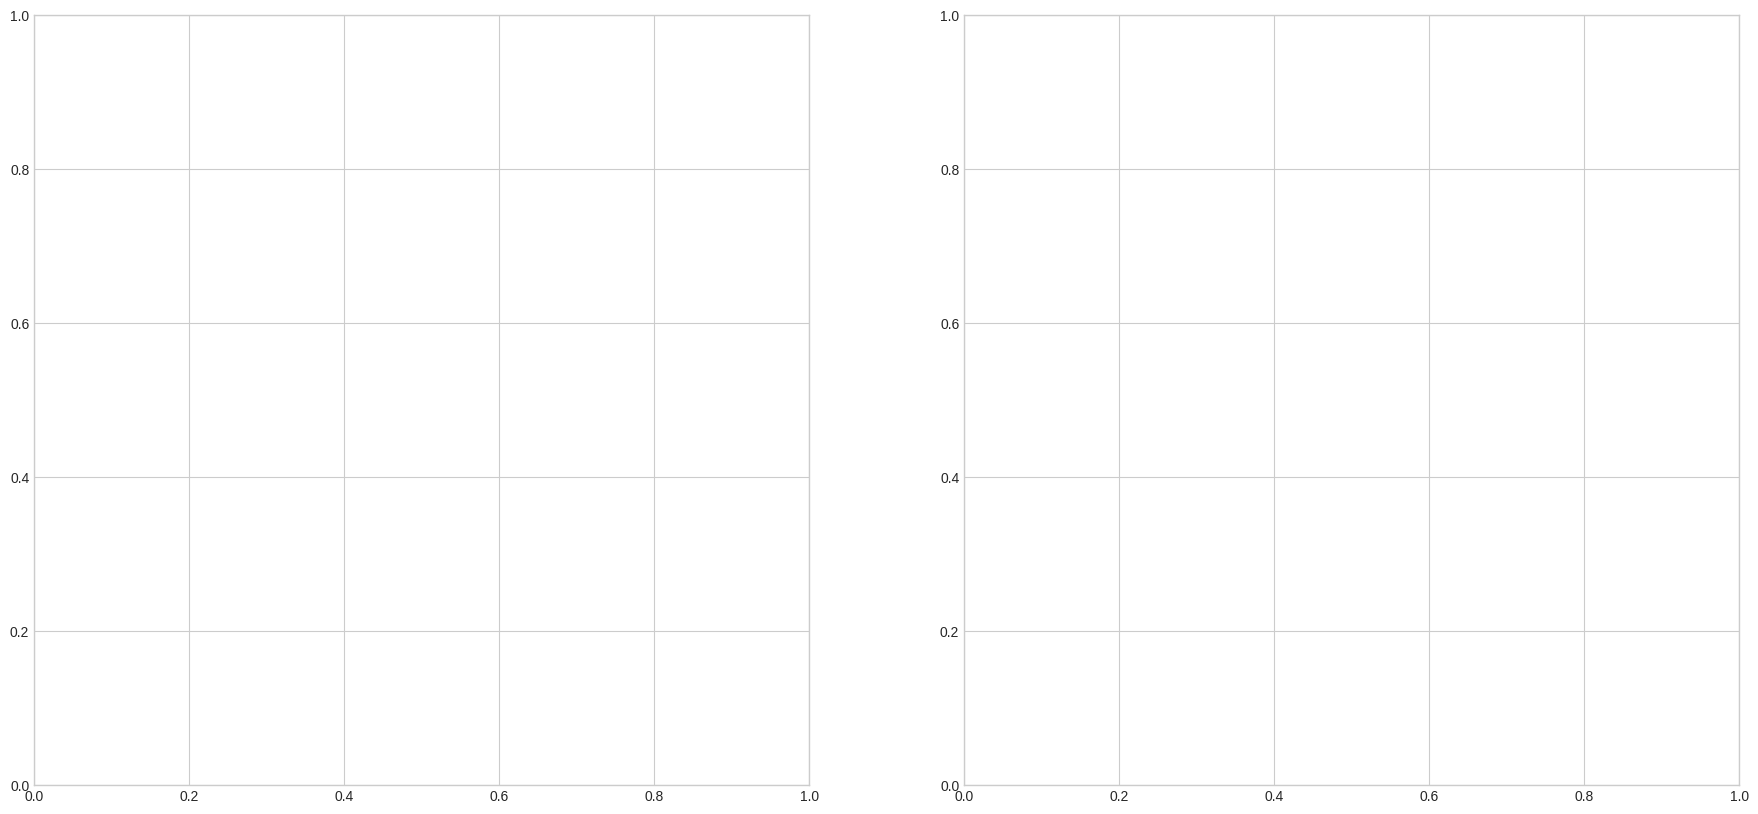

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt
import numpy as np
import timm
import os

# =============================================================================
#  1. YOUR AFMP MODEL (Slightly simplified for this standalone script)
#  (Assuming the other required classes like PCU, PredictiveRouter are defined above)
# =============================================================================

# NOTE: For this script to be self-contained, you must have your full AFMP model
# definition here. I will assume the `AFMP` class and its sub-modules
# (AFMPLayer, PredictiveRouter, PCU, etc.) are defined as in your previous script.
# I will just put a placeholder here for brevity.

# >>> PASTE YOUR FULL, WORKING AFMP MODEL DEFINITION AND ITS SUB-MODULES HERE <<<
# For example:
# class Config: ...
# class StaticGraphBuilder: ...
# class PredictiveRouter: ...
# class PCU: ...
# class TopDownAggregator: ...
# class AFMPLayer: ...
# class SparsityRegularizer: ...
# class AFMP(nn.Module): ...

# =============================================================================
#  2. EXPERIMENT SETUP AND HELPER FUNCTIONS (UPDATED)
# =============================================================================

def get_afmp_small(num_classes=100, img_size=224):
    """Builds and returns the scaled-up AFMP-Small model."""
    # This function is already correct, no changes needed.
    model = AFMP(
        num_layers=5, d_model=512, d_position=2,
        num_classes=num_classes, img_size=img_size, patch_size=16,
        sparsity=0.3, is_sparse=True, use_top_down=True
    )
    return model

def get_deit_tiny(num_classes=100, img_size=224): # <-- FIX: Add img_size argument
    """
    Builds and returns the DeiT-Tiny model from timm, configured for a specific image size.
    """
    # --- START OF FIX ---
    # Pass the img_size directly into the constructor.
    # This enables timm's automatic positional embedding interpolation.
    model = timm.create_model(
        'deit_tiny_patch16_224',
        pretrained=False,
        num_classes=num_classes,
        img_size=img_size
    )
    # --- END OF FIX ---
    return model


def measure_performance(model, device, input_tensor):
    """
    Measures peak memory and time for a single forward/backward pass.
    Returns (peak_memory_mb, time_seconds), or (None, None) on OOM error.
    """
    # Move model to the correct device
    model.to(device)

    # Create a dummy target for the loss function
    num_classes = model.num_classes if hasattr(model, 'num_classes') else 100
    target = torch.randint(0, num_classes, (input_tensor.size(0),), device=device)

    # Reset CUDA memory stats
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats(device)

    try:
        # Warm-up pass (to handle CUDA initialization overhead)
        for _ in range(5):
            output = model(input_tensor)
            if isinstance(output, tuple): # Handle models returning multiple values
                output = output[0]
            loss = nn.CrossEntropyLoss()(output, target)
            loss.backward()
            model.zero_grad()

        torch.cuda.synchronize()
        start_time = time.time()

        # The actual measurement pass
        for _ in range(10): # Average over 10 passes for stable time measurement
            output = model(input_tensor)
            if isinstance(output, tuple):
                output = output[0]
            loss = nn.CrossEntropyLoss()(output, target)
            loss.backward()
            model.zero_grad() # Clear gradients after each pass

        torch.cuda.synchronize()
        end_time = time.time()

        peak_memory_mb = torch.cuda.max_memory_allocated(device) / (1024**2)
        avg_time_sec = (end_time - start_time) / 10

        return peak_memory_mb, avg_time_sec

    except torch.cuda.OutOfMemoryError:
        print(f"--- OOM ERROR! Model could not run on this input size. ---")
        return None, None
    finally:
        # Clean up memory
        del model, input_tensor, target
        torch.cuda.empty_cache()

# =============================================================================
#  3. MAIN EXPERIMENT EXECUTION (UPDATED)
# =============================================================================

def run_scalability_experiment():
    """Main function to run the scalability test and generate plots."""

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if not torch.cuda.is_available():
        print("WARNING: CUDA not available...")
        return

    # Configuration is unchanged
    resolutions = [64, 96, 128, 160, 192, 224]
    patch_size = 16
    batch_size = 64

    results = {
        'resolutions': resolutions,
        'num_patches': [(res // patch_size)**2 for res in resolutions],
        'afmp': {'memory': [], 'time': []},
        'deit': {'memory': [], 'time': []}
    }

    # Parameter count verification is unchanged
    afmp_check = get_afmp_small()
    deit_check = get_deit_tiny()
    print(f"AFMP-Small Parameters: {sum(p.numel() for p in afmp_check.parameters())/1e6:.2f}M")
    print(f"DeiT-Tiny Parameters: {sum(p.numel() for p in deit_check.parameters())/1e6:.2f}M")
    del afmp_check, deit_check

    # --- Run the Gauntlet (UPDATED) ---
    for res in resolutions:
        num_patches = (res // patch_size)**2
        print(f"\n--- Testing Resolution: {res}x{res} (N = {num_patches} patches) ---")

        input_tensor = torch.randn(batch_size, 3, res, res, device=device)

        # --- Test AFMP-Small (unchanged) ---
        print("Testing AFMP-Small...")
        afmp_model = get_afmp_small(img_size=res)
        mem, t = measure_performance(afmp_model, device, input_tensor.clone())
        results['afmp']['memory'].append(mem)
        results['afmp']['time'].append(t)

        # --- Test DeiT-Tiny (UPDATED) ---
        print("Testing DeiT-Tiny...")
        # --- START OF FIX ---
        # Create a new model instance for each resolution
        deit_model = get_deit_tiny(img_size=res)
        # REMOVED: deit_model.patch_embed.img_size = (res, res)
        # --- END OF FIX ---
        mem, t = measure_performance(deit_model, device, input_tensor.clone())
        results['deit']['memory'].append(mem)
        results['deit']['time'].append(t)

    # Plotting function call is unchanged
    plot_results(results)


# =============================================================================
#  4. PLOTTING FUNCTION
# =============================================================================

def plot_results(results):
    """Generates and saves the final scalability plots."""

    num_patches = results['num_patches']

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

    # --- Plot 1: Memory Scaling ---
    afmp_mem = [m for m in results['afmp']['memory'] if m is not None]
    deit_mem = [m for m in results['deit']['memory'] if m is not None]

    ax1.plot(num_patches[:len(afmp_mem)], afmp_mem, 'o-', label='AFMP-Small (Ours)', color='blue', lw=2, markersize=8)
    ax1.plot(num_patches[:len(deit_mem)], deit_mem, 's--', label='DeiT-Tiny (Baseline)', color='red', lw=2, markersize=8)

    # Mark the OOM error point for DeiT
    if len(deit_mem) < len(num_patches):
        oom_patch_idx = len(deit_mem)
        oom_patch_num = num_patches[oom_patch_idx]
        ax1.scatter(oom_patch_num, deit_mem[-1] * 1.05, marker='x', color='red', s=200, zorder=10, label='DeiT OOM Error')
        ax1.text(oom_patch_num, deit_mem[-1] * 0.9, 'OOM Error', color='red', ha='center', va='top', fontsize=12, weight='bold')

    ax1.set_title('Memory Scalability: O(N) vs O(N²)', fontsize=18, weight='bold')
    ax1.set_xlabel('Number of Patches (N)', fontsize=14)
    ax1.set_ylabel('Peak GPU Memory (MB)', fontsize=14)
    ax1.legend(fontsize=12)
    ax1.tick_params(axis='both', which='major', labelsize=12)

    # --- Plot 2: Time Scaling ---
    afmp_time = [t * 1000 for t in results['afmp']['time'] if t is not None] # Convert to ms
    deit_time = [t * 1000 for t in results['deit']['time'] if t is not None] # Convert to ms

    ax2.plot(num_patches[:len(afmp_time)], afmp_time, 'o-', label='AFMP-Small (Ours)', color='blue', lw=2, markersize=8)
    ax2.plot(num_patches[:len(deit_time)], deit_time, 's--', label='DeiT-Tiny (Baseline)', color='red', lw=2, markersize=8)

    # Mark the OOM error point for DeiT
    if len(deit_time) < len(num_patches):
        oom_patch_idx = len(deit_time)
        oom_patch_num = num_patches[oom_patch_idx]
        ax2.scatter(oom_patch_num, deit_time[-1] * 1.05, marker='x', color='red', s=200, zorder=10, label='DeiT OOM Error')

    ax2.set_title('Time Scalability: O(N) vs O(N²)', fontsize=18, weight='bold')
    ax2.set_xlabel('Number of Patches (N)', fontsize=14)
    ax2.set_ylabel('Time per Pass (ms)', fontsize=14)
    ax2.legend(fontsize=12)
    ax2.tick_params(axis='both', which='major', labelsize=12)

    fig.suptitle('AFMP vs. DeiT: Scalability Analysis', fontsize=22, weight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('scalability_results.png', dpi=300)
    print("\nScalability plots saved to 'scalability_results.png'")
    plt.show()

# =============================================================================
#  5. SCRIPT EXECUTION
# =============================================================================

if __name__ == '__main__':
    # >>> PASTE YOUR FULL AFMP MODEL DEFINITION AND SUB-MODULES ABOVE THIS LINE <<<
    run_scalability_experiment()

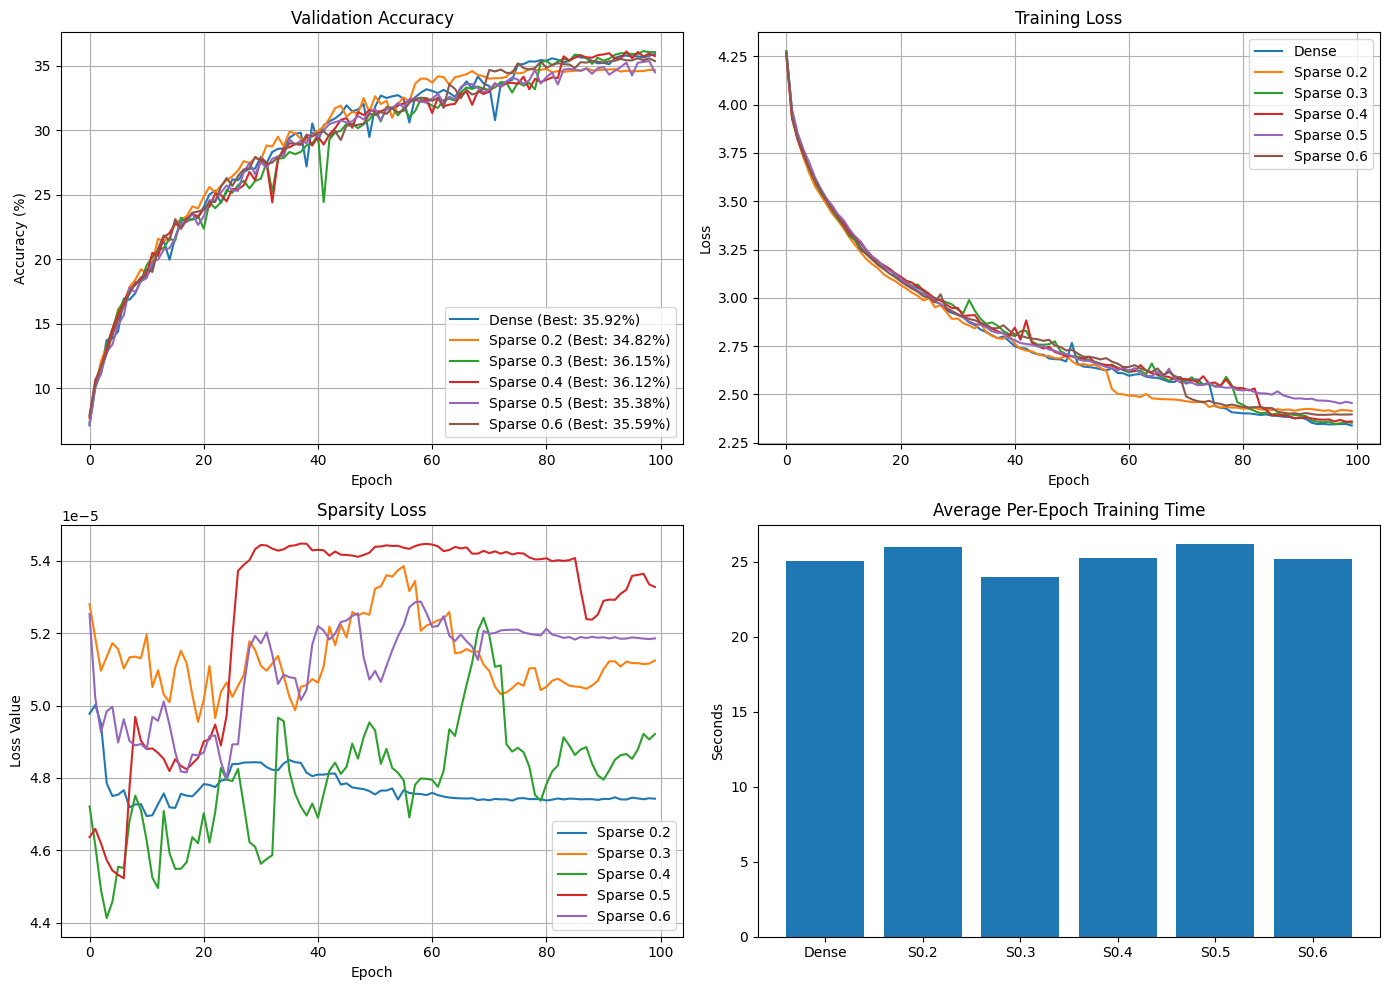

In [ ]:
import json
import matplotlib.pyplot as plt

# Load your histories from JSON
with open('results_dense (1).json', 'r') as f:
    dense_results = json.load(f)
with open('results_sparse_0.2.json', 'r') as f:
    sparse_0_2_results = json.load(f)
with open('results_sparse_0.3.json', 'r') as f:
    sparse_0_3_results = json.load(f)
with open('results_sparse_0.4.json', 'r') as f:
    sparse_0_4_results = json.load(f)
with open('results_sparse_0.5.json', 'r') as f:
    sparse_0_5_results = json.load(f)
with open('results_sparse_0.6.json', 'r') as f:
    sparse_0_6_results = json.load(f)

# Access the training histories
dense_history = dense_results['training_history']
sparse_0_2_history = sparse_0_2_results['training_history']
sparse_0_3_history = sparse_0_3_results['training_history']
sparse_0_4_history = sparse_0_4_results['training_history']
sparse_0_5_history = sparse_0_5_results['training_history']
sparse_0_6_history = sparse_0_6_results['training_history']

# Calculate best validation accuracies
dense_acc = max(dense_history['val_acc'])
sparse_0_2_acc = max(sparse_0_2_history['val_acc'])
sparse_0_3_acc = max(sparse_0_3_history['val_acc'])
sparse_0_4_acc = max(sparse_0_4_history['val_acc'])
sparse_0_5_acc = max(sparse_0_5_history['val_acc'])
sparse_0_6_acc = max(sparse_0_6_history['val_acc'])

plt.figure(figsize=(14, 10))

# 1. Validation Accuracy
plt.subplot(2, 2, 1)
plt.plot(dense_history['val_acc'], label=f'Dense (Best: {dense_acc:.2f}%)')
plt.plot(sparse_0_2_history['val_acc'], label=f'Sparse 0.2 (Best: {sparse_0_2_acc:.2f}%)')
plt.plot(sparse_0_3_history['val_acc'], label=f'Sparse 0.3 (Best: {sparse_0_3_acc:.2f}%)')
plt.plot(sparse_0_4_history['val_acc'], label=f'Sparse 0.4 (Best: {sparse_0_4_acc:.2f}%)')
plt.plot(sparse_0_5_history['val_acc'], label=f'Sparse 0.5 (Best: {sparse_0_5_acc:.2f}%)')
plt.plot(sparse_0_6_history['val_acc'], label=f'Sparse 0.6 (Best: {sparse_0_6_acc:.2f}%)')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# 2. Training Loss
plt.subplot(2, 2, 2)
plt.plot(dense_history['train_loss'], label='Dense')
plt.plot(sparse_0_2_history['train_loss'], label='Sparse 0.2')
plt.plot(sparse_0_3_history['train_loss'], label='Sparse 0.3')
plt.plot(sparse_0_4_history['train_loss'], label='Sparse 0.4')
plt.plot(sparse_0_5_history['train_loss'], label='Sparse 0.5')
plt.plot(sparse_0_6_history['train_loss'], label='Sparse 0.6')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 3. Sparsity Loss
plt.subplot(2, 2, 3)
plt.plot(sparse_0_2_history['sparsity_loss'], label='Sparse 0.2')
plt.plot(sparse_0_3_history['sparsity_loss'], label='Sparse 0.3')
plt.plot(sparse_0_4_history['sparsity_loss'], label='Sparse 0.4')
plt.plot(sparse_0_5_history['sparsity_loss'], label='Sparse 0.5')
plt.plot(sparse_0_6_history['sparsity_loss'], label='Sparse 0.6')
plt.title('Sparsity Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

# 4. Average Per-Epoch Training Time
avg_dense_time = sum(dense_history['time']) / len(dense_history['time'])
avg_sparse_0_2_time = sum(sparse_0_2_history['time']) / len(sparse_0_2_history['time'])
avg_sparse_0_3_time = sum(sparse_0_3_history['time']) / len(sparse_0_3_history['time'])
avg_sparse_0_4_time = sum(sparse_0_4_history['time']) / len(sparse_0_4_history['time'])
avg_sparse_0_5_time = sum(sparse_0_5_history['time']) / len(sparse_0_5_history['time'])
avg_sparse_0_6_time = sum(sparse_0_6_history['time']) / len(sparse_0_6_history['time'])

plt.subplot(2, 2, 4)
plt.bar(['Dense', 'S0.2', 'S0.3', 'S0.4', 'S0.5', 'S0.6'],
        [avg_dense_time, avg_sparse_0_2_time, avg_sparse_0_3_time,
         avg_sparse_0_4_time, avg_sparse_0_5_time, avg_sparse_0_6_time])
plt.title('Average Per-Epoch Training Time')
plt.ylabel('Seconds')

plt.tight_layout()
plt.savefig('comparison_results_full.png')
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
cp -r /content/visualizations_sparse/  /content/drive/MyDrive/


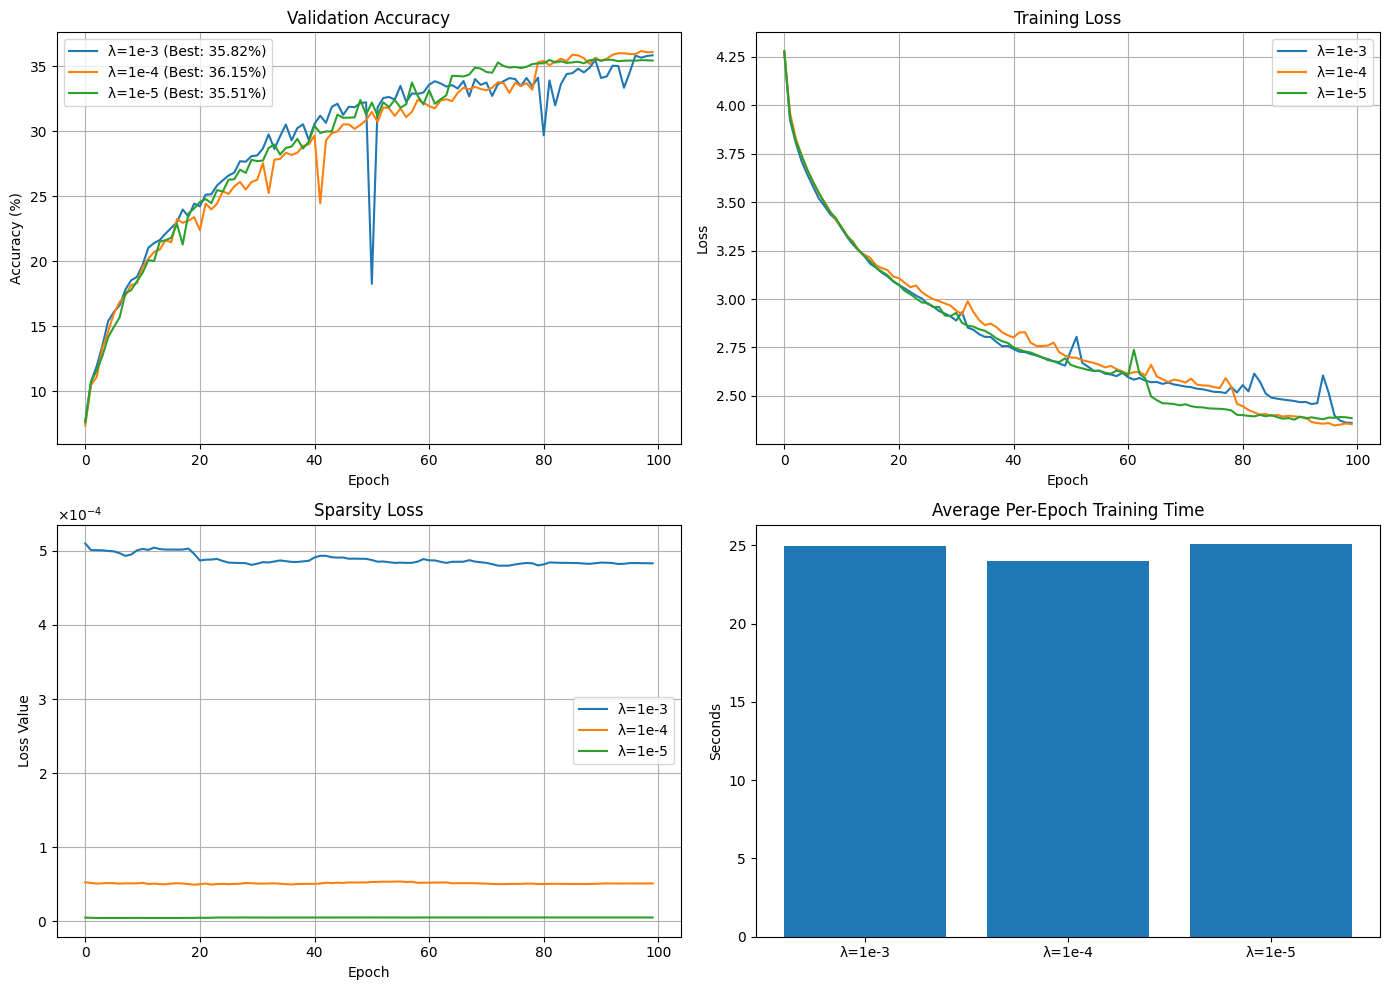

In [ ]:
import json
import matplotlib.pyplot as plt

# Load your histories from JSON
with open('/content/results_sparse_0.3_with-lambda_sparse_1e-3.json', 'r') as f:
    results_1e_3 = json.load(f)
with open('/content/results_sparse_0.3_with_lambda_sparse_1e-4.json', 'r') as f:
    results_1e_4 = json.load(f)
with open('/content/results_sparse_0.3_with_lambda_sparse_1e-5.json', 'r') as f:
    results_1e_5 = json.load(f)

# Extract training histories
history_1e_3 = results_1e_3['training_history']
history_1e_4 = results_1e_4['training_history']
history_1e_5 = results_1e_5['training_history']

# Best validation accuracies
acc_1e_3 = max(history_1e_3['val_acc'])
acc_1e_4 = max(history_1e_4['val_acc'])
acc_1e_5 = max(history_1e_5['val_acc'])

plt.figure(figsize=(14, 10))

# 1. Validation Accuracy
plt.subplot(2, 2, 1)
plt.plot(history_1e_3['val_acc'], label=f'λ=1e-3 (Best: {acc_1e_3:.2f}%)')
plt.plot(history_1e_4['val_acc'], label=f'λ=1e-4 (Best: {acc_1e_4:.2f}%)')
plt.plot(history_1e_5['val_acc'], label=f'λ=1e-5 (Best: {acc_1e_5:.2f}%)')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# 2. Training Loss
plt.subplot(2, 2, 2)
plt.plot(history_1e_3['train_loss'], label='λ=1e-3')
plt.plot(history_1e_4['train_loss'], label='λ=1e-4')
plt.plot(history_1e_5['train_loss'], label='λ=1e-5')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

import matplotlib.ticker as ticker  # Add this import at the top

# 3. Sparsity Loss (Scientific Notation for small values)
plt.subplot(2, 2, 3)
plt.plot(history_1e_3['sparsity_loss'], label='λ=1e-3')
plt.plot(history_1e_4['sparsity_loss'], label='λ=1e-4')
plt.plot(history_1e_5['sparsity_loss'], label='λ=1e-5')
plt.title('Sparsity Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.yscale('linear')  # keep it linear, just use scientific notation
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.get_major_formatter().set_powerlimits((-4, 4))  # force scientific notation for small numbers
plt.grid(True)
plt.legend()

# 4. Average Per-Epoch Training Time
avg_time_1e_3 = sum(history_1e_3['time']) / len(history_1e_3['time'])
avg_time_1e_4 = sum(history_1e_4['time']) / len(history_1e_4['time'])
avg_time_1e_5 = sum(history_1e_5['time']) / len(history_1e_5['time'])

plt.subplot(2, 2, 4)
plt.bar(['λ=1e-3', 'λ=1e-4', 'λ=1e-5'],
        [avg_time_1e_3, avg_time_1e_4, avg_time_1e_5])
plt.title('Average Per-Epoch Training Time')
plt.ylabel('Seconds')

plt.tight_layout()
plt.savefig('lambda_sparse_comparison.png')
plt.show()


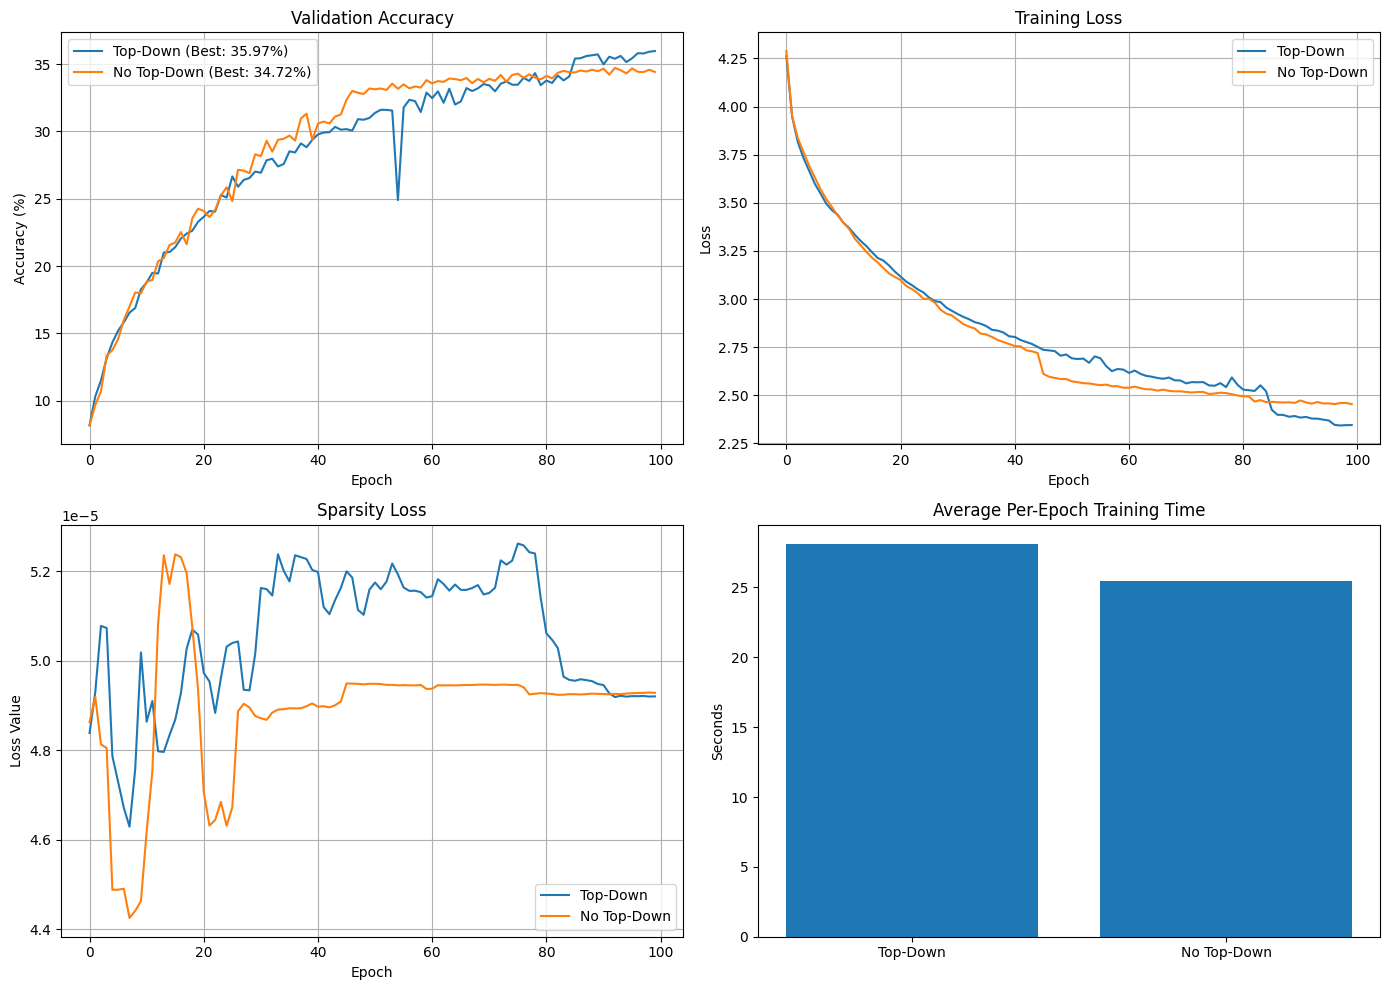

In [ ]:
import json
import matplotlib.pyplot as plt

# --- Load histories ---
with open('/content/results_sparse_with_top_down.json', 'r') as f:
    topdown_results = json.load(f)

with open('/content/results_sparse_no_top_down.json', 'r') as f:
    no_topdown_results = json.load(f)

# --- Extract training history ---
topdown_history = topdown_results['training_history']
no_topdown_history = no_topdown_results['training_history']

# --- Calculate best val accuracy ---
topdown_acc = max(topdown_history['val_acc'])
no_topdown_acc = max(no_topdown_history['val_acc'])

plt.figure(figsize=(14, 10))

# 1. Validation Accuracy
plt.subplot(2, 2, 1)
plt.plot(topdown_history['val_acc'], label=f'Top-Down (Best: {topdown_acc:.2f}%)')
plt.plot(no_topdown_history['val_acc'], label=f'No Top-Down (Best: {no_topdown_acc:.2f}%)')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# 2. Training Loss
plt.subplot(2, 2, 2)
plt.plot(topdown_history['train_loss'], label='Top-Down')
plt.plot(no_topdown_history['train_loss'], label='No Top-Down')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 3. Sparsity Loss
plt.subplot(2, 2, 3)
plt.plot(topdown_history['sparsity_loss'], label='Top-Down')
plt.plot(no_topdown_history['sparsity_loss'], label='No Top-Down')
plt.title('Sparsity Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

# 4. Average Per-Epoch Training Time
avg_topdown_time = sum(topdown_history['time']) / len(topdown_history['time'])
avg_no_topdown_time = sum(no_topdown_history['time']) / len(no_topdown_history['time'])

plt.subplot(2, 2, 4)
plt.bar(['Top-Down', 'No Top-Down'],
        [avg_topdown_time, avg_no_topdown_time])
plt.title('Average Per-Epoch Training Time')
plt.ylabel('Seconds')

plt.tight_layout()
plt.savefig('comparison_topdown_vs_no.png')
plt.show()
